<a href="https://colab.research.google.com/github/keywoong/deeplearning_with_python/blob/main/3_3_Getting_started_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.5 Classifying newswires : a multiclass classification example
#### Reuter newswire를 이용해서 multiclass classfication을 함
#### 각각의 데이터포인트는 오직 하나의 라벨을 가지고 있어야 함. 만약 여러개의 라벨을 가지고 있으면 multiclass classification 문제가 발생

## 3.5.1 The Reuter dataset
#### Reuter에서 만들어진 짧은 newswire와 주제와 관련된 데이터셋
#### 주제는 총 46개로 이루어짐. 각각의 주제 속에는 최소 10개 이상의 예시들이 있다.
#### IMDB 데이터처럼 num_words = 10000이므로 데이터 속에서 가장 자주 나타나는 단어들을 최대 10000개까지 뽑는다. 
#### 각각의 예제(train_data[10])는 정수들이 나열(word indices) 되어있는 형태이다. 

In [ ]:
# Loading the Reuters dataset
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)
print(len(train_data))
print(len(test_data))
print(train_data[10])

8982
2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


C:\Users\Key woong Bae\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\Key woong Bae\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
# Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])

print(train_labels[10]) # label은 0에서 45 사이의 주제 값을 가지고 있다.

3


## 3.5.2 Preparing the data
#### 데이터들을 벡터화한다.
#### 라벨을 벡터화하는 방법은 2가지가 있다. 정수 형태의 텐서로 label을 만듦, 원핫코딩

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension = 10000): # 시퀀스를 입력받음
    results = np.zeros((len(sequences), dimension)) # 각각의 시퀀스에 대한 index값을 가지는 
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# by using one-hot encoding
def to_one_hot(labels, dimension = 46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i,label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

## 3.5.3 Building yout network
#### 이진분류, 다중 분류 2가지 모두다 짧은 문장을 분류한다. 하지만 다중분류는 출력값의 수는 2개부터 46개까지이므로 차원이 훨씬 더 크다.
#### 각각의 Dense 층들은 정보의 병목(bottle neck)과 같은 역할을 한다. 
#### 이진 분류에서는 은닉층을 16차원으로 하였지만, 다중분류에서는 46개의 다른 클래스를 담기에는 너무 제한적이기 때문에 64개의 유닛을 갖도록 한다.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential() # 모델 정의
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### 마지막 층을 보면 46개의 은닉층을 가진다. 이는 각각의 입력값에 대해서 46차원의 벡터를 출력한다는 것을 의미한다. 이 벡터의 각각의 차원은 (총 46개) 다른 출력층 클래스이다.(카테고리)
#### 마지막 층은 `softmax함수`를 사용했다. 46개 전체의 값의 합은 1이다.
#### multiclass Classification에서는 `categorical_crossentropy`가 손실함수로 사용된다. 예측 distribution과 실제 distribution 사이의 차이를 구한 뒤, 이를 줄이는 과정을 반복한다.

## 3.5.7 Validating your approach
#### training set에서 1000개를 뽑아 검증을 한다. 

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

print(x_val.shape)
print(partial_x_train.shape)
history = model.fit(partial_x_train, partial_y_train, epochs = 20, batch_size = 512, validation_data = (x_val, y_val))

(1000, 10000)
(7982, 10000)
Epoch 1/20
16/16 [==============================] - 1s 64ms/step - loss: 2.6824 - accuracy: 0.4867 - val_loss: 1.7848 - val_accuracy: 0.6330
Epoch 2/20
16/16 [==============================] - 1s 41ms/step - loss: 1.4555 - accuracy: 0.7046 - val_loss: 1.3230 - val_accuracy: 0.7160
Epoch 3/20
16/16 [==============================] - 1s 41ms/step - loss: 1.0757 - accuracy: 0.7739 - val_loss: 1.1617 - val_accuracy: 0.7440
Epoch 4/20
16/16 [==============================] - 1s 46ms/step - loss: 0.8486 - accuracy: 0.8198 - val_loss: 1.0571 - val_accuracy: 0.7770
Epoch 5/20
16/16 [==============================] - 1s 44ms/step - loss: 0.6807 - accuracy: 0.8578 - val_loss: 0.9838 - val_accuracy: 0.7990
Epoch 6/20
16/16 [==============================] - 1s 41ms/step - loss: 0.5463 - accuracy: 0.8885 - val_loss: 0.9345 - val_accuracy: 0.8090
Epoch 7/20
16/16 [==============================] - 1s 41ms/step - loss: 0.4403 - accuracy: 0.9079 - val_loss: 0.9251 - val_ac

#### 위의 결과를 통해 loss와 accuracy의 변화 추이를 볼 수 있다. 

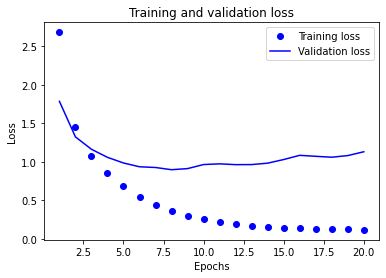

In [ ]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs = range(1, len(loss1) + 1)

plt.plot(epochs, loss1, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss1, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

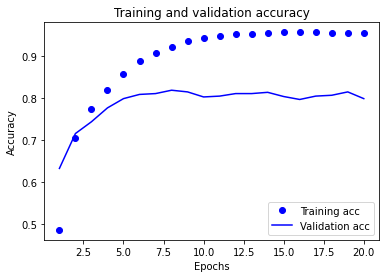

In [ ]:
# Plotting the training and validation accuracy
plt.clf() # clears the figures

acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

plt.plot(epochs, acc1, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc1, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 전체적으로 보았을 때 Training set은 손실은 줄어들고 정확도는 올라가는 반면, test set은 그렇지 않다. 이를 overfitting이라고 부른다.
#### scratch를 이용하여 새로운 네트워크를 만들어 보자.

In [ ]:
# Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs = 9, batch_size = 512, validation_data = (x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)
print(results)

Epoch 1/9
16/16 [==============================] - 1s 75ms/step - loss: 2.4380 - accuracy: 0.5420 - val_loss: 1.6366 - val_accuracy: 0.6480
Epoch 2/9
16/16 [==============================] - 1s 37ms/step - loss: 1.3427 - accuracy: 0.7136 - val_loss: 1.2743 - val_accuracy: 0.7180
Epoch 3/9
16/16 [==============================] - 1s 37ms/step - loss: 1.0144 - accuracy: 0.7843 - val_loss: 1.1337 - val_accuracy: 0.7730
Epoch 4/9
16/16 [==============================] - 1s 44ms/step - loss: 0.7995 - accuracy: 0.8358 - val_loss: 1.0345 - val_accuracy: 0.7870
Epoch 5/9
16/16 [==============================] - 1s 39ms/step - loss: 0.6388 - accuracy: 0.8675 - val_loss: 0.9736 - val_accuracy: 0.7950
Epoch 6/9
16/16 [==============================] - 1s 41ms/step - loss: 0.5096 - accuracy: 0.8981 - val_loss: 0.9288 - val_accuracy: 0.8140
Epoch 7/9
16/16 [==============================] - 1s 38ms/step - loss: 0.4137 - accuracy: 0.9141 - val_loss: 0.9152 - val_accuracy: 0.8180
Epoch 8/9
16/16 [===

#### 왼쪽이 예측값, 오른쪽이 실제값이다. 이정도면 꽤 정확하다고 볼 수 있다.

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18477292965271594

#### 차이가 약 19% 나는 것을 알 수 있다.

## 3.5.5 Generating predictions on new data
#### `predict` 함수를 통해 46개의 주제에 대한 확률을 나타낼 수 있다. 

In [ ]:
predictions = model.predict(x_test)
print(predictions.shape)
print(predictions[0].shape)

(2246, 46)
(46,)


#### 하나의 enry는 46개의 변수를 가지고 있다. 
#### 46개의 변수 벡터들의 합은 1이다.

In [ ]:
print(np.sum(predictions[0]))
print(np.sum(predictions[1]))

1.0000004
1.0


#### 가장 큰 변수 값이 가장 큰 확률을 갖는 카테고리이다.

In [ ]:
print(np.argmax(predictions[0]))
print(np.argmax(predictions[1]))
print(test_labels[1])

3
10
10


## 3.5.6 A different way to handle the labels and the loss
#### label을 encoding하는 방법은 위에서 처럼 원핫 코딩 말고도 integer tensor를 이용하는 방법이 존재한다

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

#### 위의 방법을 사용하기 위해선 `sparse_categorical_crossentropy` 라는 손실함수를 사용해야 한다. 이는 `categorical_crossentropy`와 수학적으로는 연산방법은 같지만, 다른 인터페이스를 사용한다.

## 3.5.7 The importance of having sufficiently large intermediate layers
#### 이 문제에서는 최종 출력값의 차원이 46이기 때문에 은닉층에서 하나라도 unit의 개수가 46개 이하면 안된다. 만약 이하인 경우 어떻게 되는지 보자. 아래 예시는 개수가 4인 경우이다.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

history = model.fit(partial_x_train, partial_y_train, epochs = 20, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 26ms/step - loss: 3.2252 - accuracy: 0.2033 - val_loss: 2.5999 - val_accuracy: 0.5190
Epoch 2/20
63/63 [==============================] - 1s 20ms/step - loss: 2.1260 - accuracy: 0.5371 - val_loss: 1.8300 - val_accuracy: 0.5430
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 1.6436 - accuracy: 0.5534 - val_loss: 1.6312 - val_accuracy: 0.5560
Epoch 4/20
63/63 [==============================] - 1s 20ms/step - loss: 1.4595 - accuracy: 0.5895 - val_loss: 1.5427 - val_accuracy: 0.5930
Epoch 5/20
63/63 [==============================] - 1s 21ms/step - loss: 1.3346 - accuracy: 0.6107 - val_loss: 1.4962 - val_accuracy: 0.6010
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 1.2339 - accuracy: 0.6195 - val_loss: 1.4746 - val_accuracy: 0.5960
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 1.1424 - accuracy: 0.6481 - val_loss: 1.4641 - val_accuracy: 0.6370
Epoch 8/20
63

In [ ]:
val_acc1 = history.history['val_accuracy']
print('accuracy : ', val_acc1[19])

accuracy :  0.6790000200271606


#### 이를 보면 validation accuracy가 약 71%임을 알 수 있다. 이는 중간의 은닉층의 차원이 너무 낮기 때문이다.

## 3.5.9 Wrapping up